In [1]:
import chainer
from chainer.datasets import mnist, split_dataset_random
from chainer.dataset import concat_examples
import matplotlib.pyplot as plt
from chainer import iterators, Chain
import chainer.links as L
import chainer.functions as F
from chainer import optimizers
import numpy as np
from chainer import cuda

device=-1

In [2]:
train_val, test = mnist.get_mnist(withlabel=True, ndim=3)
train, valid = split_dataset_random(train_val, 50000, seed=0)

if device >= 0:
    print('process')
    for i in train_val:
        cuda.to_gpu(i[0])
    for i in test:
        cuda.to_gpu(i[0])
    print('process end')


batchsize=512

train_iter = iterators.SerialIterator(train, batchsize)
valid_iter = iterators.SerialIterator(
    valid, batchsize, repeat=False, shuffle=False)
test_iter = iterators.SerialIterator(
    test, batchsize, repeat=False, shuffle=False)

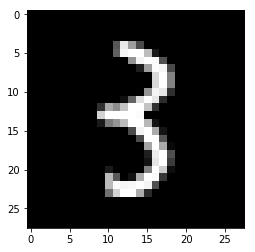

In [3]:
plt.imshow(train[0][0][0], cmap='gray')

In [4]:
class CNN(chainer.Chain):
    def __init__(self):
        super(CNN, self).__init__(
            conv1 = L.Convolution2D(1, 20, 5),
            conv2 = L.Convolution2D(20, 50, 5),
            l1 = L.Linear(800, 500),
            l2 = L.Linear(500, 500),
            l3 = L.Linear(500, 10)
        )
    
    def __call__(self, x):
        c1 = F.max_pooling_2d(F.relu(self.conv1(x)), 2)
        c2 = F.max_pooling_2d(F.relu(self.conv2(c1)), 2)
        h1 = F.relu(self.l1(c2))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

In [5]:
from chainer import training
from chainer.training import extensions

model = L.Classifier(CNN())
if device >= 0:
    model.to_gpu()
    
optimizer = optimizers.Adam()
optimizer.setup(model)
updater = training.StandardUpdater(train_iter, optimizer, device=device)

max_epoch = 5

trainer = training.Trainer(
    updater, (max_epoch, 'epoch'), out='mnist_cnn')

trainer.extend(extensions.LogReport())
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.Evaluator(valid_iter, model, device=device), name='val')
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'val/main/loss', 'val/main/accuracy', 'elapsed_time']))
trainer.extend(extensions.PlotReport(['main/loss', 'val/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'val/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.extend(extensions.dump_graph('main/loss'))

In [122]:
trainer.run()

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy  elapsed_time
1           0.354037    0.900809       0.108548       0.96933            106.541       
2           0.0761867   0.976503       0.0722816      0.977424           222.995       
3           0.0498743   0.984858       0.0497957      0.985323           336.015       
4           0.0363953   0.989298       0.0423858      0.986592           447.612       
5           0.0297176   0.991231       0.0388405      0.987667           576.003       


In [125]:
evaluator = extensions.Evaluator(test_iter, model)
results = evaluator()
round(results['main/accuracy'], 4)

0.9898

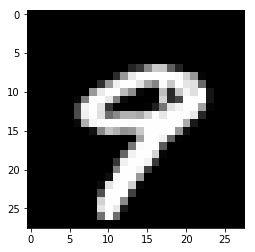

9

In [152]:
image=test[9][0]
plt.imshow(image[0], cmap='gray')
plt.show()

model.predictor(np.array([image])).data.argmax()